In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from keras.layers import Dense , LSTM , Dropout , Bidirectional
from keras.models import Sequential
from datetime import datetime
from numpy import sqrt
import warnings
import joblib
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv("C:/Users/annbl/Downloads/Bitcoin Price Predictions/coin_Bitcoin.csv")
df = df.dropna()
df['Date'] = pd.to_datetime(df['Date']).dt.date
df.set_index('Date', inplace=True)
df = df.drop(['SNo', 'Symbol', 'Name'], axis=1)

In [4]:
values = df['Close'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
np.mean(values)

6711.291

In [5]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

2093 898


In [6]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

2092
897


In [7]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

2092
897


In [8]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

model = Sequential()
model.add(Bidirectional(LSTM(32)))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1))
model.build(input_shape= (trainX.shape[0], trainX.shape[1], trainX.shape[2]))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (2092, 64)             │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (2092, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (2092, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (2092, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (2092, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (2092, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,345 (99.00 KB)

 Trainable params: 25,345 (99.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
def train_model(model, loss, optimizer, trainX, trainY):

  model.compile(loss=loss, optimizer=optimizer)
  #train model
  history = model.fit(trainX, trainY, epochs=30, batch_size= 200,  validation_data = (testX, testY))
  # plot cost
  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend()
  plt.show()

def evaluate_model(model, testX, testY):
  yhat = model.predict(testX)
  plt.title('Curve of actual value and predicted value on the scale used in training')
  plt.plot(yhat, label='predict')
  plt.plot(testY, label='true')
  plt.legend()
  plt.show()

  yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  mse = mean_squared_error(testY_inverse, yhat_inverse)
  r2 = r2_score(testY_inverse, yhat_inverse)
  mae = mean_absolute_error(testY_inverse, yhat_inverse)
  evs = explained_variance_score(testY_inverse, yhat_inverse)
  rmse= sqrt(mse)

  print("Model: LSTM")
  print("Mean Squared Error:", mse)
  print("R-squared:", r2)
  print("Mean Absolute Error:", mae)
  print("Explained Variance Score:", evs)
  print("RMSE:", rmse)

  plt.title('Actual value curve and predicted value in US dollars')
  plt.plot(yhat_inverse, label='predict')
  plt.plot(testY_inverse, label='actual', alpha=0.5)
  plt.legend()
  plt.show()

  model.save('model_BTC.h5')

Epoch 1/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.0032 - val_loss: 0.0821
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 0.0558
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.2666e-04 - val_loss: 0.0214
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3333e-04 - val_loss: 0.0052
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4768e-04 - val_loss: 0.0054
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5263e-04 - val_loss: 0.0035
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1285e-04 - val_loss: 0.0036
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2431e-04 - val_loss: 0.0035
Epoch 9/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9708e-05 - val_loss: 0.0032
Epoch 10/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0151e-04 - val_loss: 0.0030
Epoch 11/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.1971e-05 - val_loss: 0.0026
Epoch 12/30
11/11 ━━━━━━━━━━━━━━━━━━━

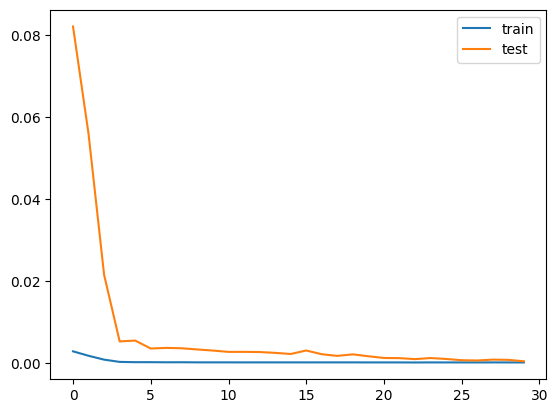

In [10]:
train_model(model, 'mse', 'adam', trainX, trainY)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


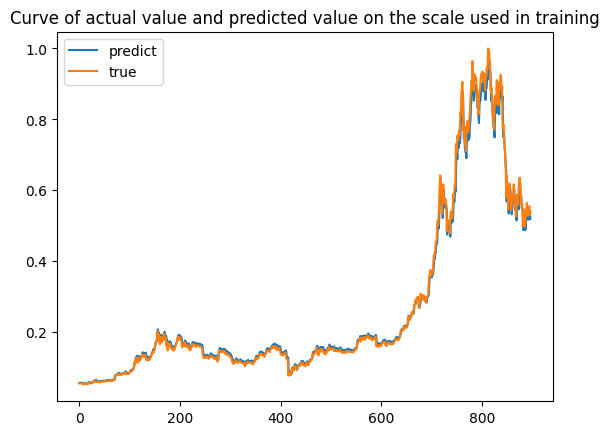

Model: LSTM
Mean Squared Error: 1442365.1
R-squared: 0.9942010150860735
Mean Absolute Error: 693.8806
Explained Variance Score: 0.9942299127578735
RMSE: 1200.9851


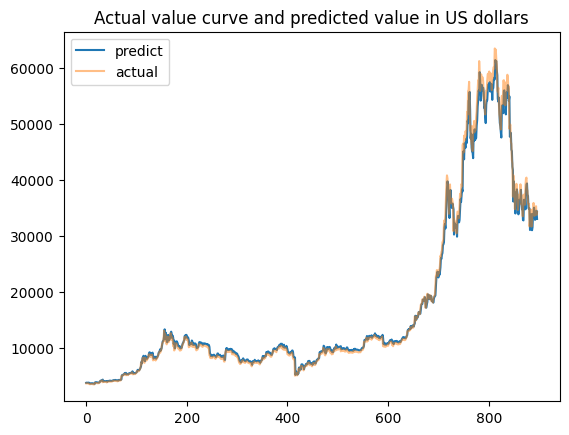

In [11]:
evaluate_model(model, testX, testY)

In [12]:
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [13]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

def baseline(history):
  return np.mean(history)

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

def predict_next_day(model, testX, testY):
  yhat_inverse = scaler.inverse_transform(model.predict(testX).reshape(-1, 1))
  testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

  show_plot([testY_inverse[0:200], yhat_inverse[201],baseline(testY_inverse[201])], 1, 'Next day prediction')

  print('predicted value of day 201: ', yhat_inverse[201])
  print('Actual value of day 201: ', testY_inverse[201])

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
predicted value of day 201:  [11691.278]
Actual value of day 201:  [11523.579]


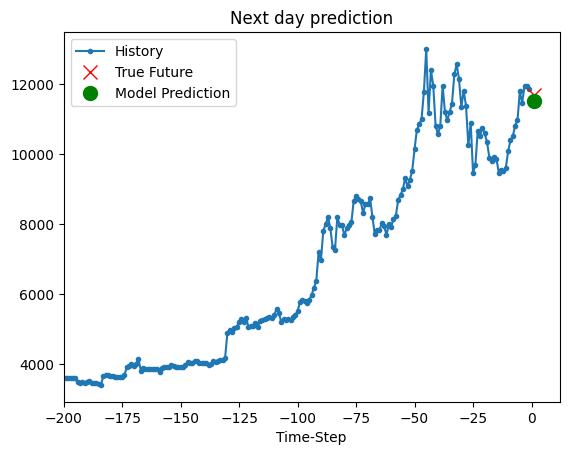

In [14]:
predict_next_day(model, testX, testY)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


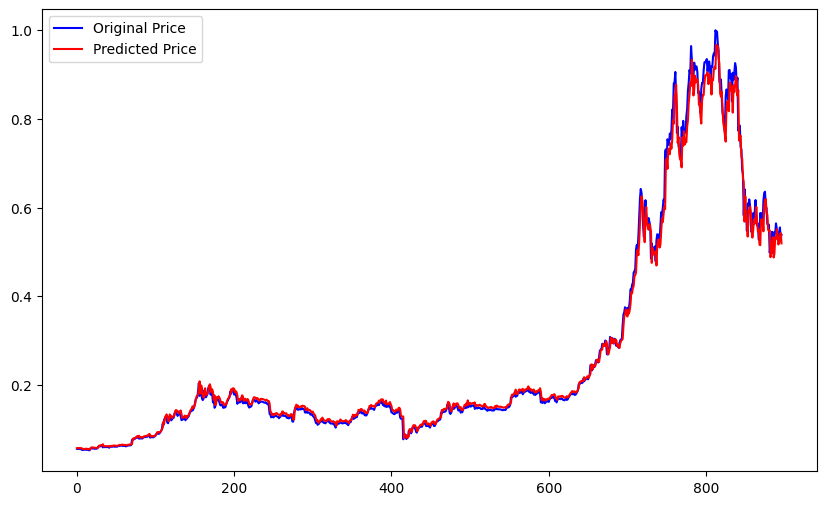

In [15]:
yhat = model.predict(testX)
plt.figure(figsize=(10, 6))
plt.plot(testY,'b',label="Original Price")
plt.plot(yhat,'r',label="Predicted Price")
plt.legend()
plt.show()

In [ ]:
def predict_price(model, scaler, user_input):
    try:
        # Reshape and scale the input
        user_input_reshaped = user_input.reshape(-1, 1)
        user_input_scaled = scaler.transform(user_input_reshaped).reshape(1, -1, 1)

        # Predict
        prediction = model.predict(user_input_scaled)
        prediction_reshaped = np.repeat(prediction, user_input_scaled.shape[1]).reshape(1, -1)

        # Inverse transform
        prediction_inverse = scaler.inverse_transform(
            np.concatenate((user_input_scaled.reshape(1, -1), prediction_reshaped), axis=0)
        )[1]

        return prediction_inverse[1]
    except Exception as e:
        print("Error during prediction:", e)
        return None

print("BTC Price Prediction System")
print("---------------------------")
high = float(input("Enter the highest price: "))
low = float(input("Enter the lowest price: "))
open = float(input("Enter the open price: "))
close = float(input("Enter the close price: "))
volume = float(input("Enter the volume: "))
user_input = np.array([[high,low,open,close,volume]])
predicted_value = predict_price(model, scaler, user_input)
print('Predicted Weighted Price:', predicted_value)

BTC Price Prediction System
---------------------------
Enter the highest price: 221.557
Enter the lowest price: 4.28965
Enter the open price: 144.2568
Enter the close price: 568.2354
Enter the volume: 12165
1/1 [==============================] - 0s 36ms/step
Predicted Weighted Price: 4589.213266486962
